# Pulseq

<a target="_blank" href="https://colab.research.google.com/github/ctr/pulseq_mrzero_demo/blob/main/Pulseq_MRZero_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [4]:
# setup
# it might be worth  pdating setup tools and pip
#!pip install -U setuptools pip
!pip install pypulseq
# install or uninstall (if there are multiple versions installed) CuPy
#!pip install cupy-cuda12x
# or
#!pip install cupy-cuda11x
#!pip uninstall cupy-cuda12x

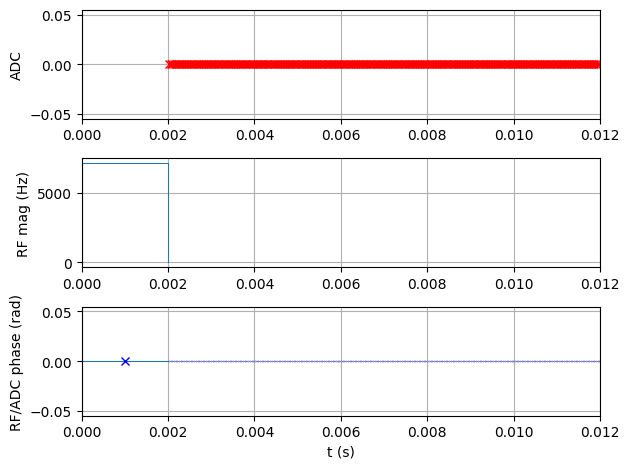

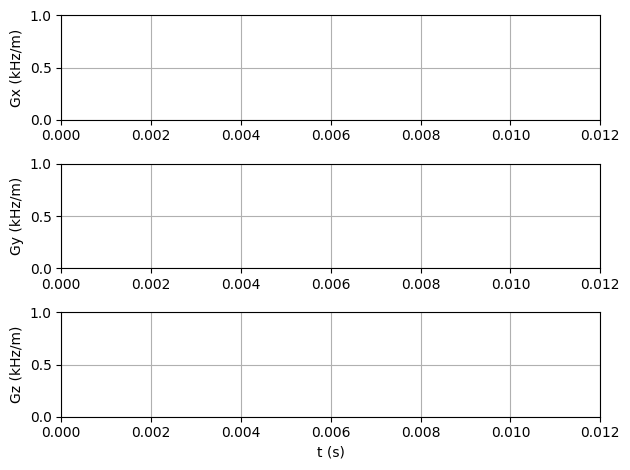

'cd6c94343fe193f136d8af5a9b954c16'

In [5]:
# FID sequence

# Custom sequence
import pypulseq as pp

# Define hardware limits
system = pp.Opts(max_grad=32, grad_unit='mT/m', max_slew=130, slew_unit='mT/m/ms')

# Create sequence object
seq = pp.Sequence(system=system)

# Design Gradient ADC and RF events
Nx = 256 # matrix size

# RF hard pulse
rf90 = pp.make_block_pulse(flip_angle=90, duration = 2e-3, system=system)

# ADC readout
adc = pp.make_adc(num_samples=Nx, duration=1e-2, system=system)

# Add the above events to the sequence object
seq.add_block(rf90)
seq.add_block(adc)

# Visualize the sequence
seq.plot()

# Save the .seq file
seq.write('mySeq_FID.seq')

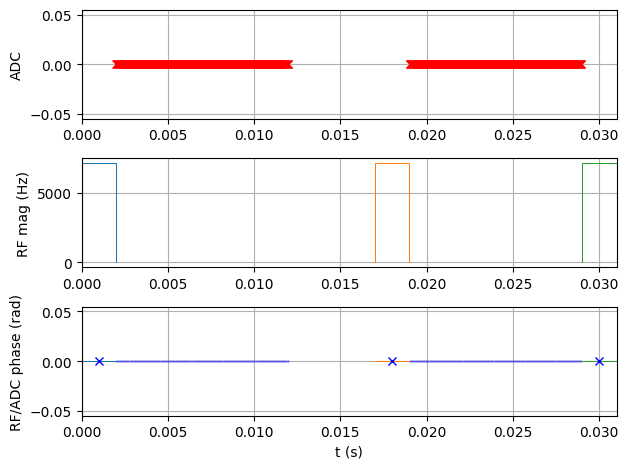

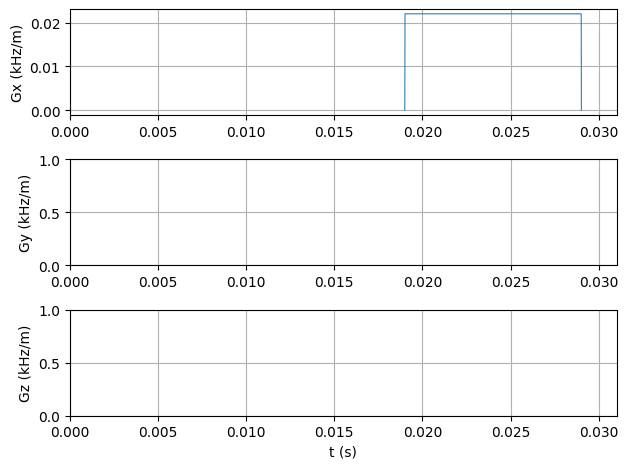

'9090c5db0e2fc281c443365e9b70c209'

In [6]:
# Modified FID sequence
import pypulseq as pp

# Define hardware limits
system = pp.Opts(max_grad=32, grad_unit='mT/m', max_slew=130, slew_unit='mT/m/ms')

# Create sequence object
seq = pp.Sequence(system=system)

# Design Gradient ADC and RF events
Nx = 256 # matrix size
fov = 220e-3 # field of view
delta_k = fov / Nx

# RF hard pulse
rf90 = pp.make_block_pulse(flip_angle=90, duration = 2e-3, system=system)

# ADC readout
adc = pp.make_adc(num_samples=Nx, duration=1e-2, system=system)

# Dummy block (delay)
dummy = pp.make_delay(5e-3)

# Frequency encode, trapezoidal gradient event
gx = pp.make_trapezoid(channel='x', flat_area=Nx * delta_k, flat_time=1e-2, system=system)


# Add the above events to the sequence object
seq.add_block(rf90)
seq.add_block(adc)
seq.add_block(dummy)
seq.add_block(rf90)
seq.add_block(adc, gx)
seq.add_block(rf90)

# Visualize the sequence
seq.plot()

# Save the .seq file
seq.write('mySeq_mod_FID.seq')

Timing check passed successfully


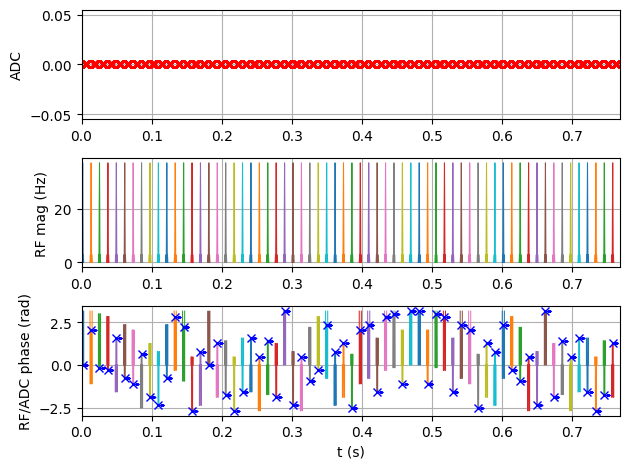

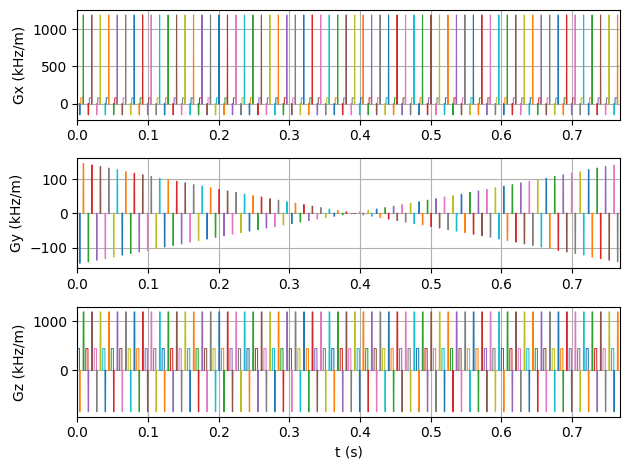

Number of blocks: 320
Number of events:
RF:     64
Gx:    192
Gy:    128
Gz:    192
ADC:     64
Delay:      0
Sequence duration: 0.768000 s
TE: 0.005010 s
TR: 0.012000 s
Flip angle: 10.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 4.06 mm
Spatial resolution: 4.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 1190476 145349 1190476 Hz/m == 27.96 3.41 27.96 mT/m
Max slew rate: 6265664160 1038205980 6349206349 Hz/m/s == 147.16 24.38 149.13 T/m/s
Max absolute gradient: 1689850 Hz/m == 39.69 mT/m
Max absolute slew rate: 8.92159e+09 Hz/m/s == 209.55 T/m/s


In [7]:
# Gradient Echo sequence
import math
import numpy as np
import pypulseq as pp


def main(plot: bool, write_seq: bool, seq_filename: str = "gre_pypulseq.seq"):
    # ======
    # SETUP
    # ======
    # Create a new sequence object
    seq = pp.Sequence()
    fov = 256e-3  # Define FOV and resolution
    # lower resolution to speed up MRZero recon
    #Nx = 256
    #Ny = 256
    Nx = 64
    Ny = 64
    alpha = 10  # flip angle
    slice_thickness = 3e-3  # slice
    TR = 12e-3  # Repetition time
    TE = 5e-3  # Echo time

    rf_spoiling_inc = 117  # RF spoiling increment

    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=150,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )

    # ======
    # CREATE EVENTS
    # ======
    rf, gz, _ = pp.make_sinc_pulse(
        flip_angle=alpha * math.pi / 180,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.42,
        time_bw_product=4,
        system=system,
        return_gz=True,
    )
    # Define other gradients and ADC events
    delta_k = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * delta_k, flat_time=3.2e-3, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2, duration=1e-3, system=system
    )
    gz_reph = pp.make_trapezoid(
        channel="z", area=-gz.area / 2, duration=1e-3, system=system
    )
    phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

    # gradient spoiling
    gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_k, system=system)
    gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    delay_TE = (
        np.ceil(
            (
                TE
                - pp.calc_duration(gx_pre)
                - gz.fall_time
                - gz.flat_time / 2
                - pp.calc_duration(gx) / 2
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    delay_TR = (
        np.ceil(
            (
                TR
                - pp.calc_duration(gz)
                - pp.calc_duration(gx_pre)
                - pp.calc_duration(gx)
                - delay_TE
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )

    assert np.all(delay_TE >= 0)
    assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

    rf_phase = 0
    rf_inc = 0

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # Loop over phase encodes and define sequence blocks
    for i in range(Ny):
        rf.phase_offset = rf_phase / 180 * np.pi
        adc.phase_offset = rf_phase / 180 * np.pi
        rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
        rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

        seq.add_block(rf, gz)
        gy_pre = pp.make_trapezoid(
            channel="y",
            area=phase_areas[i],
            duration=pp.calc_duration(gx_pre),
            system=system,
        )
        seq.add_block(gx_pre, gy_pre, gz_reph)
        seq.add_block(pp.make_delay(delay_TE))
        seq.add_block(gx, adc)
        gy_pre.amplitude = -gy_pre.amplitude
        seq.add_block(pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil)

    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed. Error listing follows:")
        [print(e) for e in error_report]

    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot()

    seq.calculate_kspace()

    # Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within
    # slew-rate limits
    rep = seq.test_report()
    print(rep)

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        # Prepare the sequence output for the scanner
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness])
        seq.set_definition(key="Name", value="gre")

        seq.write(seq_filename)


if __name__ == "__main__":
    #main(plot=False, write_seq=True)
    main(plot=True, write_seq=True)

Timing check passed successfully


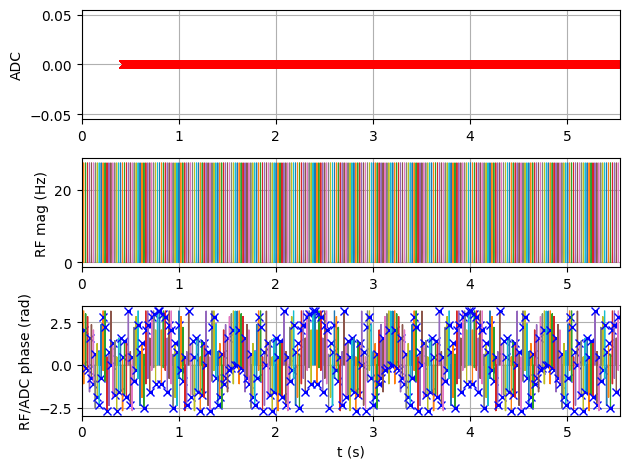

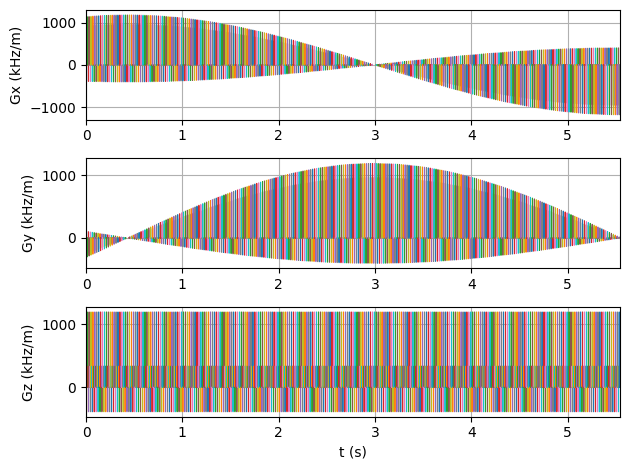

In [8]:
#Radial GRE

import numpy as np
import pypulseq as pp


def main(plot: bool, write_seq: bool, seq_filename: str = "gre_radial_pypulseq.seq"):
    # ======
    # SETUP
    # ======
    seq = pp.Sequence()  # Create a new sequence object
    fov = 260e-3
    Nx = 320  # Define FOV and resolution
    alpha = 10  # Flip angle
    slice_thickness = 3e-3  # Slice thickness
    TE = 8e-3  # Echo time
    TR = 20e-3  # Repetition time
    Nr = 256  # Number of radial spokes
    N_dummy = 20  # Number of dummy scans
    delta = np.pi / Nr  # Angular increment

    rf_spoiling_inc = 117  # RF spoiling increment

    # Set system limits
    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=120,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )

    # ======
    # CREATE EVENTS
    # ======
    # Create alpha-degree slice selection pulse and gradient
    rf, gz, _ = pp.make_sinc_pulse(
        apodization=0.5,
        duration=4e-3,
        flip_angle=alpha * np.pi / 180,
        slice_thickness=slice_thickness,
        system=system,
        time_bw_product=4,
        return_gz=True,
    )

    # Define other gradients and ADC events
    deltak = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * deltak, flat_time=6.4e-3 / 5, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2 - deltak / 2, duration=2e-3, system=system
    )
    gz_reph = pp.make_trapezoid(
        channel="z", area=-gz.area / 2, duration=2e-3, system=system
    )
    # Gradient spoiling
    gx_spoil = pp.make_trapezoid(channel="x", area=0.5 * Nx * deltak, system=system)
    gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    delay_TE = (
        np.ceil(
            (
                TE
                - pp.calc_duration(gx_pre)
                - gz.fall_time
                - gz.flat_time / 2
                - pp.calc_duration(gx) / 2
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    delay_TR = (
        np.ceil(
            (
                TR
                - pp.calc_duration(gx_pre)
                - pp.calc_duration(gz)
                - pp.calc_duration(gx)
                - delay_TE
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    assert np.all(delay_TR) > pp.calc_duration(gx_spoil, gz_spoil)
    rf_phase = 0
    rf_inc = 0

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    for i in range(-N_dummy, Nr + 1):
        rf.phase_offset = rf_phase / 180 * np.pi
        adc.phase_offset = rf_phase / 180 * np.pi

        rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
        rf_phase = divmod(rf_inc + rf_phase, 360.0)[1]

        seq.add_block(rf, gz)
        phi = delta * (i - 1)
        seq.add_block(*pp.rotate(gx_pre, gz_reph, angle=phi, axis="z"))
        seq.add_block(pp.make_delay(delay_TE))
        if i > 0:
            seq.add_block(*pp.rotate(gx, adc, angle=phi, axis="z"))
        else:
            seq.add_block(*pp.rotate(gx, angle=phi, axis="z"))
        seq.add_block(
            *pp.rotate(gx_spoil, gz_spoil, pp.make_delay(delay_TR), angle=phi, axis="z")
        )

    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed! Error listing follows:")
        print(error_report)

    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot()

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness])
        seq.set_definition(key="Name", value="gre_rad")
        seq.write(seq_filename)


if __name__ == "__main__":
    main(plot=True, write_seq=True)

# MR Zero

In [ ]:
!pip install MRzeroCore

In [ ]:
# Generate Brain phantoms - this can take a while
import MRzeroCore as mr0

mr0.generate_brainweb_phantoms("output/brainweb", "3T")

VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])


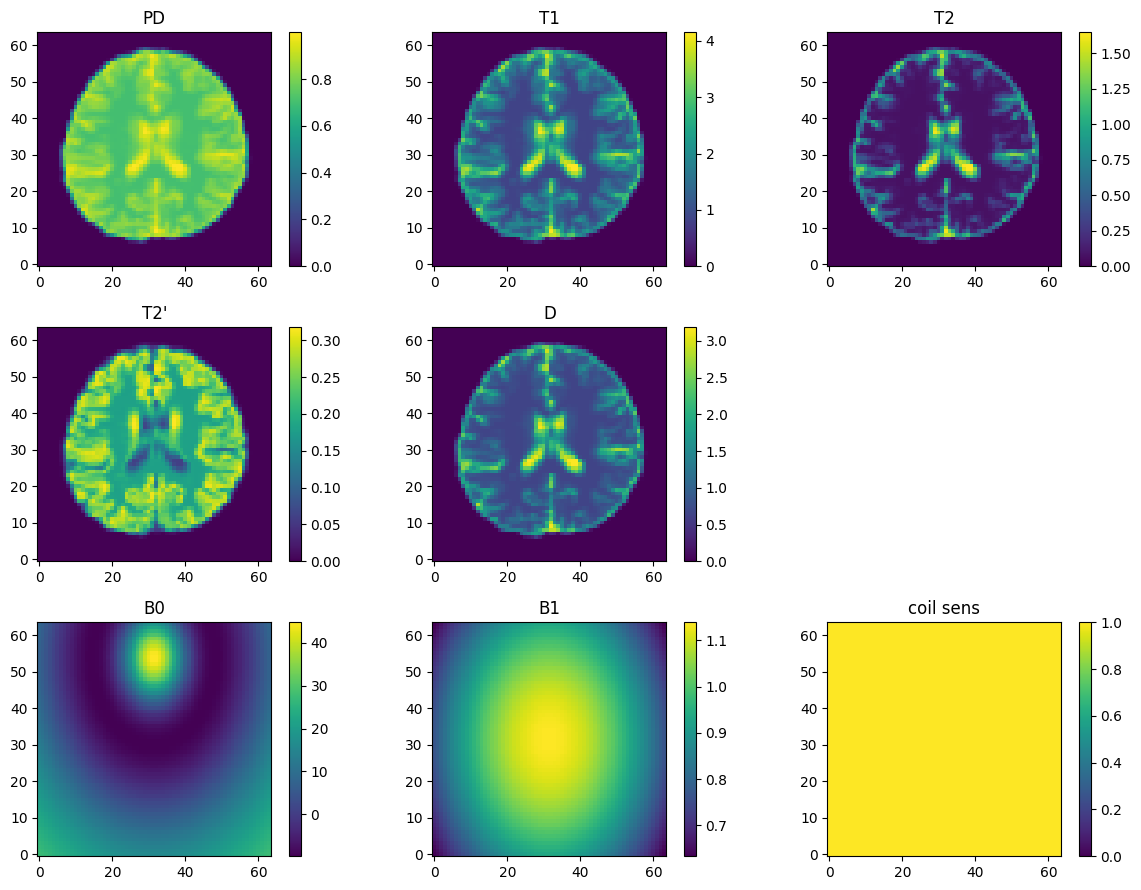

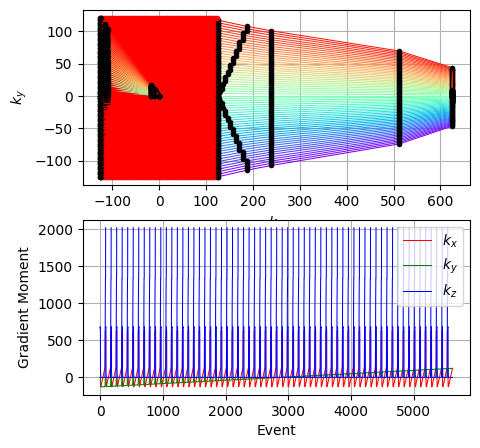

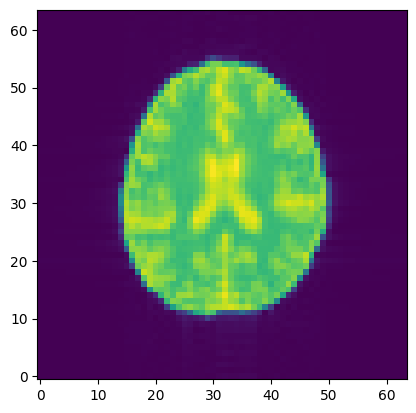

In [ ]:
import torch
import matplotlib.pyplot as plt

phantom = mr0.VoxelGridPhantom.load("output/brainweb/subject05_3T.npz")
phantom = phantom.interpolate(64, 64, 32).slices([16])
phantom.plot()
data = phantom.build()

n_read = 64
n_phase = 64

seq = mr0.Sequence.import_file("gre_pypulseq.seq")
seq.plot_kspace_trajectory()

graph = mr0.compute_graph(seq, data, 200, 1e-3)
signal = mr0.execute_graph(graph, seq, data, print_progress=False)

kspace = signal.view(n_phase, n_read)
reco = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(kspace)))

plt.figure()
plt.imshow(reco.abs(), origin="lower")
plt.show()